# Neural Networks

## Using a Neural Network to predict Taxi Fares

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/jeffprosise/Applied-Machine-Learning/main/Chapter%202/Data/taxi-fares.csv",parse_dates=["pickup_datetime"])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1


In [2]:
#Using the following code to transform the data into something suitable for training

from math import sqrt
 
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
 
for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance
 
df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
 
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.head()

,fare_amount,day_of_week,pickup_time,distance
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
9,8.9,3.0,16.0,1.365739


In [3]:
#Creating the neural network with an input layer that accepts 3 values(day,time,distance) 2 hidden layers with 512 neurons and an output layer with a 
#single neuron

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2048      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265,217
Trainable params: 265,217
Non-trainable params: 0
_________________________________________________________________


In [4]:
# separating the feature cols from the label label col. then setting the validation_split to 0.2 to validate the network, and training for 100 epochs
# and a batch size of 100

x = df.drop('fare_amount', axis=1)
y = df['fare_amount']

hist = model.fit(x, y, validation_split=0.2, epochs=100, batch_size=100)

Epoch 1/100
187/187 [==============================] - 3s 14ms/step - loss: 2.8704 - mae: 2.8704 - val_loss: 2.3929 - val_mae: 2.3929
Epoch 2/100
187/187 [==============================] - 3s 14ms/step - loss: 2.3999 - mae: 2.3999 - val_loss: 2.4118 - val_mae: 2.4118
Epoch 3/100
187/187 [==============================] - 2s 8ms/step - loss: 2.3937 - mae: 2.3937 - val_loss: 2.3505 - val_mae: 2.3505
Epoch 4/100
187/187 [==============================] - 2s 8ms/step - loss: 2.3863 - mae: 2.3863 - val_loss: 2.3832 - val_mae: 2.3832
Epoch 5/100
187/187 [==============================] - 2s 9ms/step - loss: 2.3626 - mae: 2.3626 - val_loss: 2.3575 - val_mae: 2.3575
Epoch 6/100
187/187 [==============================] - 2s 9ms/step - loss: 2.3611 - mae: 2.3611 - val_loss: 2.3803 - val_mae: 2.3803
Epoch 7/100
187/187 [==============================] - 2s 9ms/step - loss: 2.3475 - mae: 2.3475 - val_loss: 2.3717 - val_mae: 2.3717
Epoch 8/100
187/187 [==============================] - 2s 8ms/step 

[]

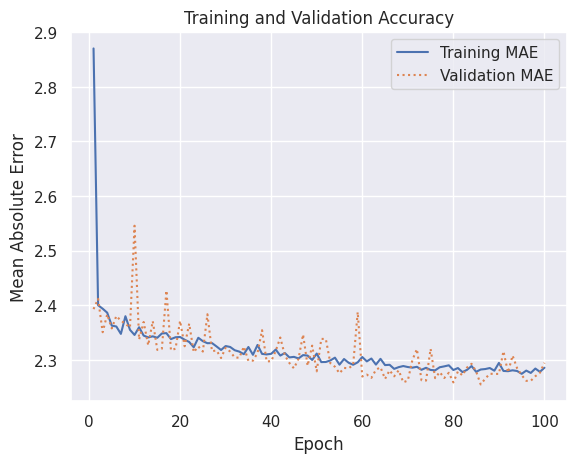

In [5]:
#using the history object returned by fit to plot the training and validation accuracy for each epoch

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

In [6]:
# The final MAE was about 2.25 which means that on average a taxi fare predicted vby this network should be accurate to within about $2.25

In [7]:
#calculating the R2 score 

from sklearn.metrics import r2_score

r2_score(y, model.predict(x))

729/729 [==============================] - 2s 3ms/step


0.7320945930169434

In [8]:
#Making a prediction on what it will cost to hire a taxi for a 2-mile trip at 5:00pm on Friday

import numpy as np

model.predict(np.array([[4, 17, 2.0]]))

1/1 [==============================] - 0s 86ms/step


array([[10.41534]], dtype=float32)

In [9]:
#Now predicting the fare for  2-mile trip taken at 5:00pm on Sat

model.predict(np.array([[5, 17, 2.0]]))

1/1 [==============================] - 0s 31ms/step


array([[10.247794]], dtype=float32)

## Training a Neural Net to Dectect Credit Card Fraud

In [10]:
#loading the dataset

df = pd.read_csv("/content/drive/MyDrive/Data/creditcard.csv")
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [11]:
#Dropping the time col, dividing the dataset into features and label and spliting the dataset into training and testing

from sklearn.model_selection import train_test_split

x = df.drop(["Time","Class"],axis=1)
y = df["Class"]


x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=0)

In [12]:
from sklearn import metrics
#Creating the neural network for binary classification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128,activation = "relu",input_dim=29))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3840      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Training the model

hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=100)

Epoch 1/10
2279/2279 [==============================] - 6s 2ms/step - loss: 0.0199 - accuracy: 0.9988 - val_loss: 0.0051 - val_accuracy: 0.9993
Epoch 2/10
2279/2279 [==============================] - 7s 3ms/step - loss: 0.0173 - accuracy: 0.9992 - val_loss: 0.0119 - val_accuracy: 0.9993
Epoch 3/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0084 - accuracy: 0.9993 - val_loss: 0.0055 - val_accuracy: 0.9993
Epoch 4/10
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 5/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 6/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0073 - accuracy: 0.9994 - val_loss: 0.0093 - val_accuracy: 0.9993
Epoch 7/10
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0098 - accuracy: 0.9994 - val_loss: 0.0062 - val_accuracy:

[]

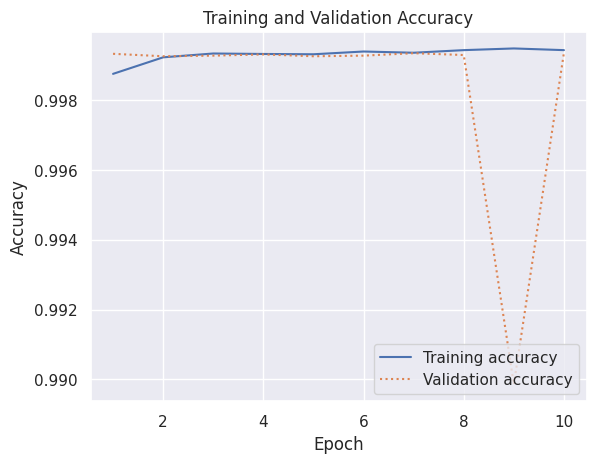

In [14]:
# plotting the training and validation accuracy using the per-epoch values in the hist object

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

1781/1781 [==============================] - 2s 1ms/step


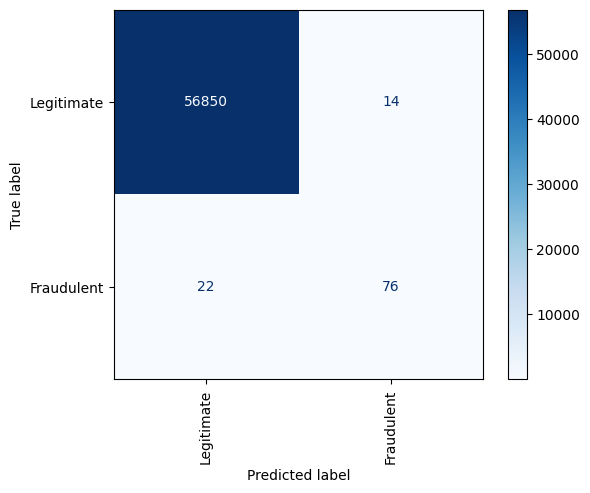

In [15]:
# Using a confusion matrix to visualize how the model performs during testing with data it wasn't trained with

from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
y_predicted = model.predict(x_test) > 0.5
labels = ['Legitimate', 'Fraudulent']
cmd.from_predictions(y_test, y_predicted, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

## Multiclass Classification with Neural Networks

## Training a Neural Network to Recognize Faces

In [16]:
#importing the libs and dataset limiting the number of faces to 100 per person

from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)



['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


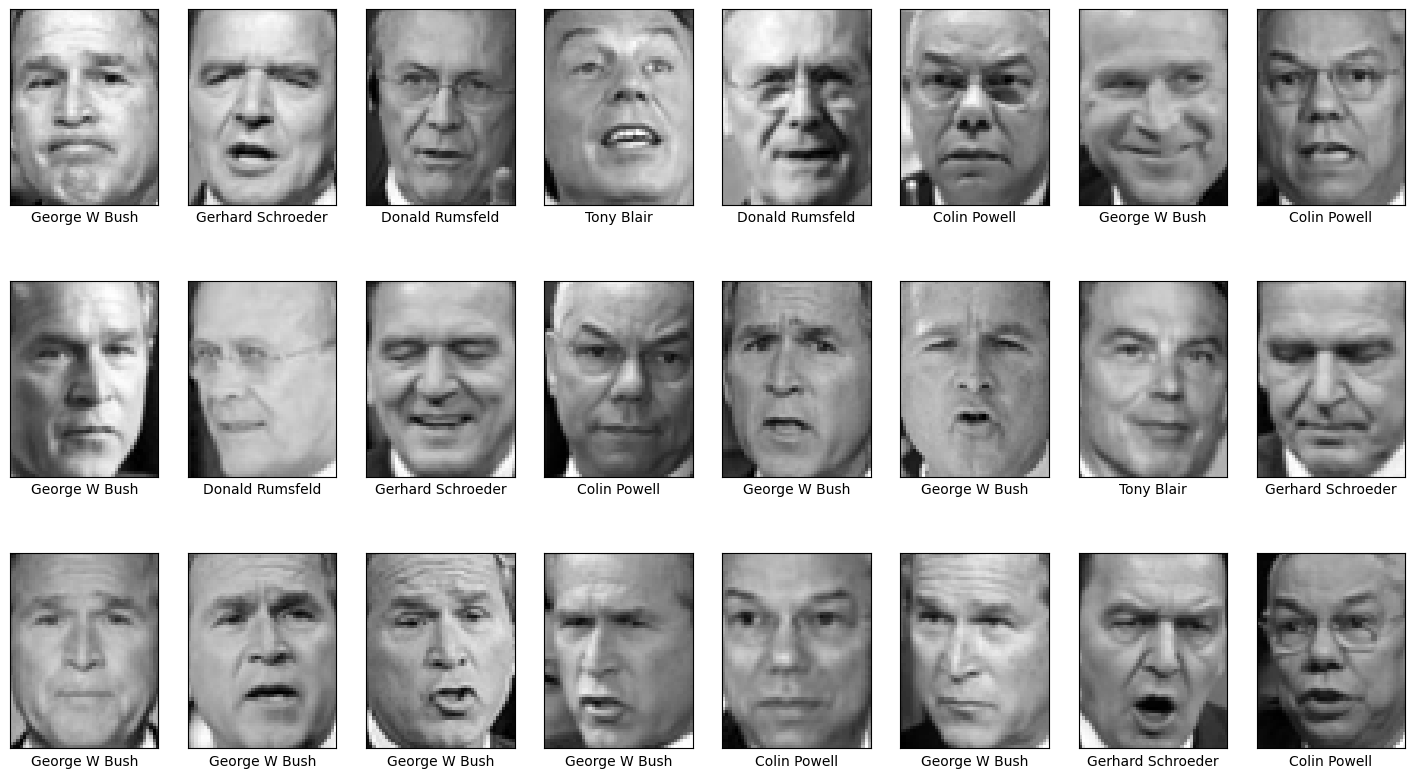

In [17]:
#Showing the first 24 images in the dataset and the people who belong

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

<Axes: >

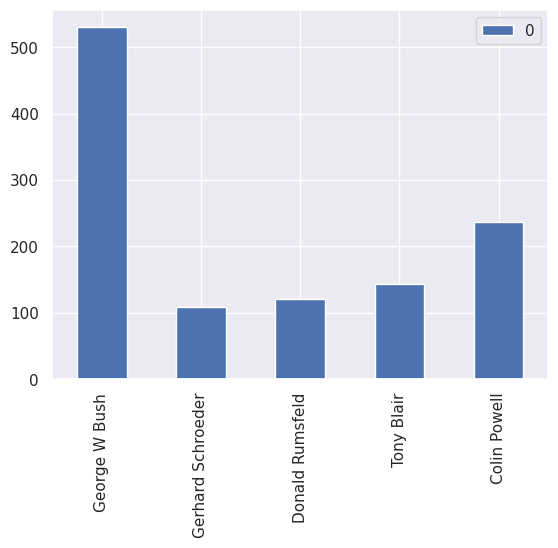

In [18]:
#checking the balance by generating a histogram

from collections import Counter
import seaborn as sns
sns.set()

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [19]:
#Reducing the dataset to 100 images of each person

import numpy as np

mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

In [20]:
#Splitting the data into training and testing. Setting aside 20% for testing

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_faces, y_faces, train_size=0.8, stratify=y_faces, random_state=0)

In [21]:
#Creating a NN with one hidden layer with 512 neurons and using sparse_categorical_crossentropy as the loss function and softmax as the 
#activation function

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
 
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               1492480   
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 1,495,045
Trainable params: 1,495,045
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training the network

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Epoch 1/100
20/20 [==============================] - 1s 24ms/step - loss: 3.3733 - accuracy: 0.2100 - val_loss: 2.3173 - val_accuracy: 0.2300
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 1.7856 - accuracy: 0.2925 - val_loss: 1.5568 - val_accuracy: 0.3500
Epoch 3/100
20/20 [==============================] - 0s 17ms/step - loss: 1.4562 - accuracy: 0.3650 - val_loss: 1.3671 - val_accuracy: 0.4400
Epoch 4/100
20/20 [==============================] - 0s 18ms/step - loss: 1.2669 - accuracy: 0.5025 - val_loss: 1.4891 - val_accuracy: 0.4500
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 1.2819 - accuracy: 0.4975 - val_loss: 1.1627 - val_accuracy: 0.5900
Epoch 6/100
20/20 [==============================] - 0s 24ms/step - loss: 1.1796 - accuracy: 0.5400 - val_loss: 1.1572 - val_accuracy: 0.5800
Epoch 7/100
20/20 [==============================] - 0s 25ms/step - loss: 1.1171 - accuracy: 0.5750 - val_loss: 1.2592 - val_accuracy: 0.5000
Epoch 

[]

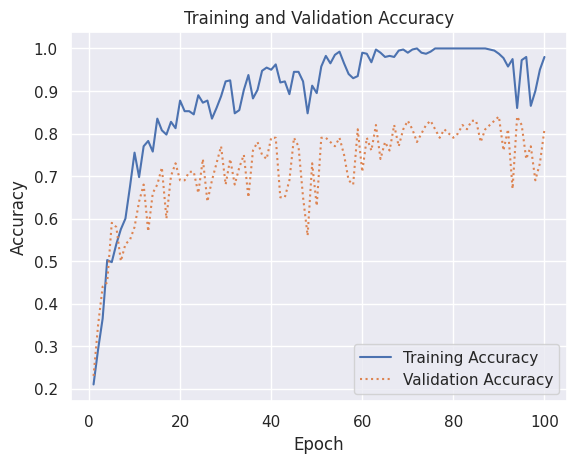

In [23]:
#Plotting the training and validation accuracy

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 [==============================] - 0s 7ms/step


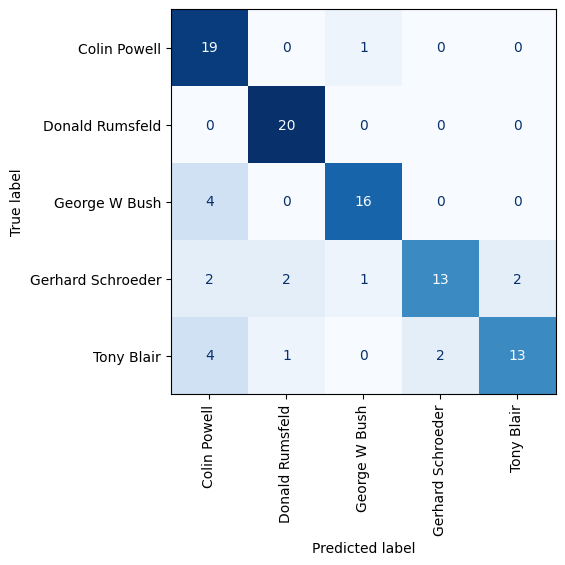

In [24]:
#using a confusion matrix to visual how the network performs against test data

from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=faces.target_names, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

## Saving and Loading Models

In [25]:
# Saving the model in Keras H5 format

model.save("my_model.h5")

#Saving the model in TensoFlow's native format

model.save("my_model")